<font size="5">Customer Segmentation & Profiling</font>

<br />

**In progress**

In this project, customer clusters are analyzed in order to profile the characteristics of each cluster, with the ultimate goal of predicting the cluster of new leads and understanding how their cluster effects their spending score.
- Both predicted and true clusters are evaluated through unsupervised and supervised methods, respectively

<br />

<u>Business Challenge<u/>
- "An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of the new market is similar to their existing market.
- In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them; they plan to use the same strategy on new markets and have identified 2627 new potential customers.
- You are required to help the manager to predict the right group of the new customers."

<br />

<u>Data Notes<u/>
- Dataset contains 8068 customer records labelled for training, and 2627 test records
  - Data features consist of 10 customer attributes (numeric or categorical) of differing ranges
  - Data labels contain the provided/true cluster for each instance
  - Source (data + scenario): https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data

In [1]:
#Imports
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

 #Configure pandas for high dimensionality dataframes
pd.set_option('display.max_columns', None)

In [2]:
#Load data + review attributes
cust_train = pd.read_csv(r'C:\Users\Public\cust_train.csv')
cust_test = pd.read_csv(r'C:\Users\Public\cust_test.csv')
print(cust_train.info(), cust_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-n

In [3]:
#Preview data
cust_train.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B


In [4]:
#Remove ID column
cust_train = cust_train.drop(cust_train[['ID']], axis=1)

In [5]:
#Check train label balance proportions
cust_train['Segmentation'].value_counts(normalize=True)

Segmentation
D    0.281111
A    0.244422
C    0.244175
B    0.230293
Name: proportion, dtype: float64

In [6]:
#Count missing values
cust_train.isna().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [7]:
#Count missing values
cust_test.isna().sum()

ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
dtype: int64

In [8]:
#Drop records with missing values
cust_train = cust_train.dropna()
print("Records after dropping missing values: "+str(len(cust_train)))

Records after dropping missing values: 6665


In [9]:
cust_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6665 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           6665 non-null   object 
 1   Ever_Married     6665 non-null   object 
 2   Age              6665 non-null   int64  
 3   Graduated        6665 non-null   object 
 4   Profession       6665 non-null   object 
 5   Work_Experience  6665 non-null   float64
 6   Spending_Score   6665 non-null   object 
 7   Family_Size      6665 non-null   float64
 8   Var_1            6665 non-null   object 
 9   Segmentation     6665 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 572.8+ KB


In [10]:
#Convert float cols to int
cust_train.astype({'Work_Experience':int, 'Family_Size':int})

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1,Low,4,Cat_4,D
2,Female,Yes,67,Yes,Engineer,1,Low,1,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0,High,2,Cat_6,B
5,Male,Yes,56,No,Artist,0,Average,2,Cat_6,C
6,Male,No,32,Yes,Healthcare,1,Low,3,Cat_6,C
...,...,...,...,...,...,...,...,...,...,...
8062,Male,Yes,41,Yes,Artist,0,High,5,Cat_6,B
8064,Male,No,35,No,Executive,3,Low,4,Cat_4,D
8065,Female,No,33,Yes,Healthcare,1,Low,1,Cat_6,D
8066,Female,No,27,Yes,Healthcare,1,Low,4,Cat_6,B


In [11]:
#Updated balance
cust_train['Segmentation'].value_counts(normalize=True)

Segmentation
D    0.263616
C    0.258065
A    0.242461
B    0.235859
Name: proportion, dtype: float64

In [12]:
#Detect categorical object/string columns
obj_tr = (cust_train.dtypes == 'object')
obj_cols_tr = list(obj_tr[obj_tr].index)
obj_cols_tr

['Gender',
 'Ever_Married',
 'Graduated',
 'Profession',
 'Spending_Score',
 'Var_1',
 'Segmentation']

In [13]:
#List categories and levels
cat_count=0
for col in obj_cols_tr:
    print(pd.DataFrame(cust_train[col].value_counts()))
    cat_count += len(cust_train[col].value_counts())
print('\nTotal # categorical levels/values: ', cat_count)

        count
Gender       
Male     3677
Female   2988
              count
Ever_Married       
Yes            3944
No             2721
           count
Graduated       
Yes         4249
No          2416
               count
Profession          
Artist          2192
Healthcare      1077
Entertainment    809
Doctor           592
Engineer         582
Executive        505
Lawyer           500
Marketing        233
Homemaker        175
                count
Spending_Score       
Low              3999
Average          1662
High             1004
       count
Var_1       
Cat_6   4476
Cat_4    849
Cat_3    634
Cat_2    362
Cat_7    166
Cat_1    104
Cat_5     74
              count
Segmentation       
D              1757
C              1720
A              1616
B              1572

Total # categorical levels/values:  29


In [14]:
#Encode categorical variables depending on relationships between values

 #LabelEncoder for label ('Segmentation'); maps labels alphabetically (A=0, D=3)
enc_lab = LabelEncoder()
 #OrdinalEncoder for 'Spending_Score
  #Assign Spend_Score categories to continuous values; Low=1, high=3
enc_ord = OrdinalEncoder(categories=[['skip','Low','Average','High']])
 #OneHotEncoder for remaining categorical features
enc_OneH = OneHotEncoder(sparse_output=False, dtype=int)

In [15]:
#Encode labels
cust_train['Segmentation'] = enc_lab.fit_transform(cust_train['Segmentation'])
cust_train['Segmentation'].head(3)

0    3
2    1
3    1
Name: Segmentation, dtype: int32

In [16]:
#Encode 'Spending_Score'
cust_train['Spending_Score'] = enc_ord.fit_transform(cust_train[['Spending_Score']])
cust_train['Spending_Score'].head(3)

0    1.0
2    1.0
3    3.0
Name: Spending_Score, dtype: float64

In [17]:
#Confirm transformations
cust_train.head(3)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,1.0,4.0,Cat_4,3
2,Female,Yes,67,Yes,Engineer,1.0,1.0,1.0,Cat_6,1
3,Male,Yes,67,Yes,Lawyer,0.0,3.0,2.0,Cat_6,1


In [18]:
#Remaining categorical vars (not label or ordinal)
cols_rem = [col for col in obj_cols_tr if col not in ['Spending_Score', 'Segmentation']]
cols_rem

['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']

Before continuing and exploding the remaining string attributes out into separate one-hot columns, lets look at a scatter matrix of the numeric features

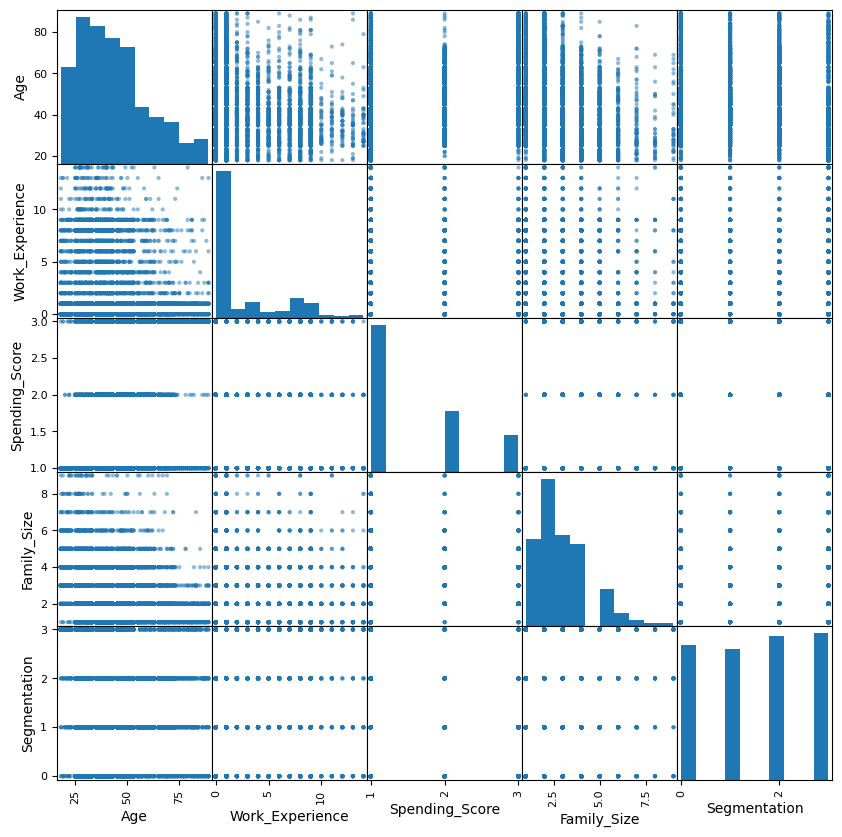

In [19]:
pd.plotting.scatter_matrix(cust_train, grid=True, figsize=(10,10))
plt.show()

In [20]:
#Encode features in dataframe
encoded = pd.DataFrame(enc_OneH.fit_transform(cust_train[['Gender','Ever_Married','Graduated','Profession','Var_1']]), columns=enc_OneH.get_feature_names_out())
 #Preview One-Hot features
print(encoded.shape)
encoded.head()

(6665, 22)


,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [21]:
#Review cust_train index after dropping records
print(cust_train.shape)
cust_train.head(3)

(6665, 10)


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,1.0,4.0,Cat_4,3
2,Female,Yes,67,Yes,Engineer,1.0,1.0,1.0,Cat_6,1
3,Male,Yes,67,Yes,Lawyer,0.0,3.0,2.0,Cat_6,1


In [22]:
#Reset cust_train index before concatenating to prevent record corruption due to incongruent indexes
cust_train.reset_index(drop=True, inplace=True)
print(cust_train.shape)
cust_train.head(3)

(6665, 10)


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,1.0,4.0,Cat_4,3
1,Female,Yes,67,Yes,Engineer,1.0,1.0,1.0,Cat_6,1
2,Male,Yes,67,Yes,Lawyer,0.0,3.0,2.0,Cat_6,1


In [23]:
#Combine original and one hot encoded dataframes
cust_train = pd.concat([cust_train, encoded], axis=1)
 #Drop pre-transformation features
cust_train = cust_train.drop(cust_train[['Gender','Ever_Married','Graduated','Profession','Var_1']], axis=1)

In [24]:
#Resetting index before concatenation prevented 1146 rows from corrupting as they did previously
cust_train.isna().sum()

Age                         0
Work_Experience             0
Spending_Score              0
Family_Size                 0
Segmentation                0
Gender_Female               0
Gender_Male                 0
Ever_Married_No             0
Ever_Married_Yes            0
Graduated_No                0
Graduated_Yes               0
Profession_Artist           0
Profession_Doctor           0
Profession_Engineer         0
Profession_Entertainment    0
Profession_Executive        0
Profession_Healthcare       0
Profession_Homemaker        0
Profession_Lawyer           0
Profession_Marketing        0
Var_1_Cat_1                 0
Var_1_Cat_2                 0
Var_1_Cat_3                 0
Var_1_Cat_4                 0
Var_1_Cat_5                 0
Var_1_Cat_6                 0
Var_1_Cat_7                 0
dtype: int64

In [25]:
#Move Label to last column
cust_train['Segmentation'] = cust_train.pop('Segmentation')

In [26]:
#Preview full pre-processed df
cust_train.head(3)

,Age,Work_Experience,Spending_Score,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation
0,22,1.0,1.0,4.0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,3
1,67,1.0,1.0,1.0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,67,0.0,3.0,2.0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1


In [27]:
#Review summary statistics
cust_train.describe()

,Age,Work_Experience,Spending_Score,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation
count,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000,6665.000000
mean,43.536084,2.629107,1.550638,2.841110,0.448312,0.551688,0.408252,0.591748,0.362491,0.637509,0.328882,0.088822,0.087322,0.121380,0.075769,0.161590,0.026257,0.075019,0.034959,0.015604,0.054314,0.095124,0.127382,0.011103,0.671568,0.024906,1.542836
std,16.524054,3.405365,0.740806,1.524743,0.497358,0.497358,0.491547,0.491547,0.480755,0.480755,0.469842,0.284508,0.282327,0.326593,0.264648,0.368102,0.159909,0.263441,0.183689,0.123946,0.226652,0.293408,0.333425,0.104791,0.469678,0.155851,1.122723
min,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,41.000000,1.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
75%,53.000000,4.000000,2.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000
max,89.000000,14.000000,3.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


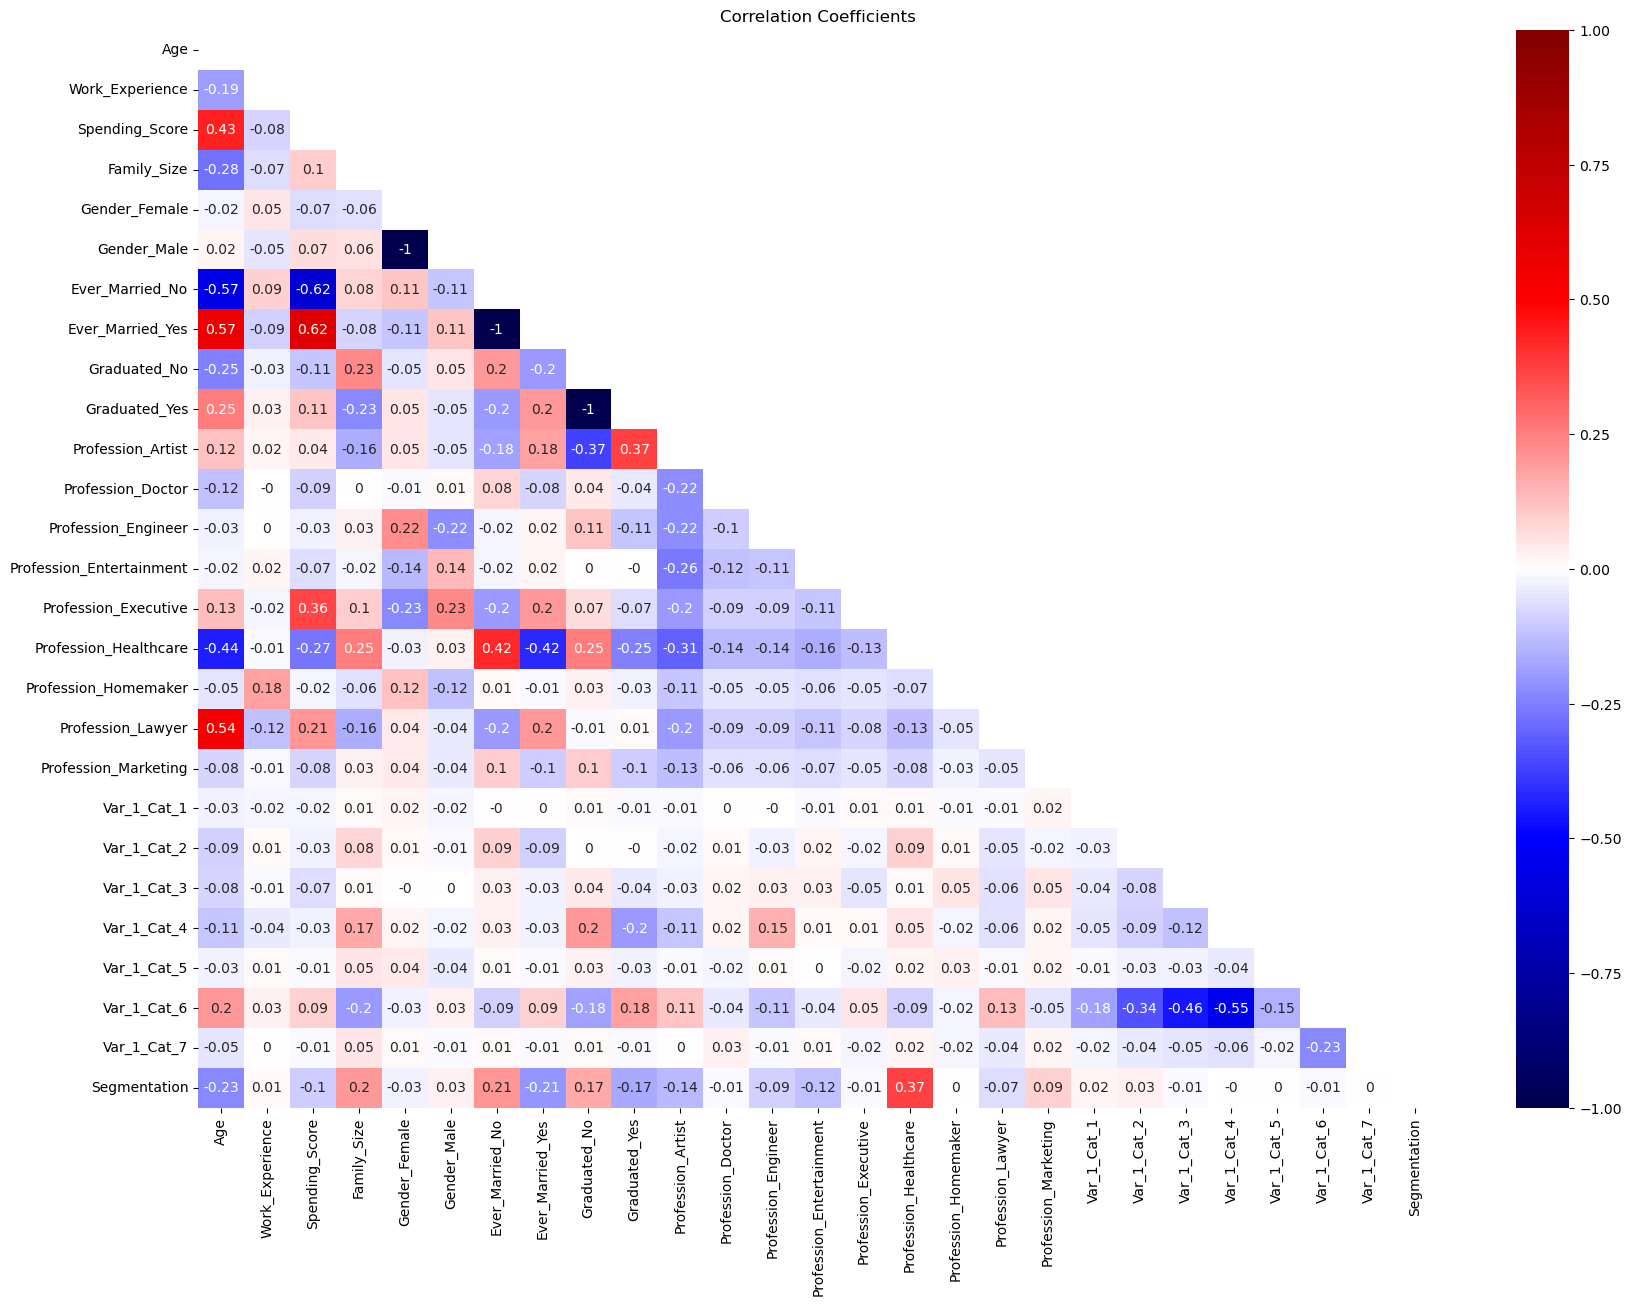

In [28]:
#Create correlation matrix
corr_matrix = cust_train.corr().round(2)

#Plot masked heatmap
mask = np.triu(np.ones_like(corr_matrix))
plt.figure(figsize=(20,14))

sns.heatmap(corr_matrix, annot=True, cmap='seismic', mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficients')
plt.show()

We can observe some simple associations in the correlation coefficients:
- Married people, lawyers, people who have graduated, and (to some degree) people in the anonymized Var_1 category '6' are correlated with greater ages
  - Healthcare workers tend to be younger
- Married people, lawyers, and exectives correlate with higher spending scores
  - Unmarried people and healthcare workers tend to spend less
 
Now lets scale the training data, split it into train/test sets, and get baseline predictions + accuracy from a Logistic Regression algorithm

In [29]:
#Save column names
col_names = pd.Series(cust_train.columns)

#Scale data + reapply column titles
scaler = StandardScaler()

cust_train_sc = pd.DataFrame(scaler.fit_transform(cust_train))
cust_train_sc.rename(columns=col_names, inplace=True)

cust_train_sc.head(3)

,Age,Work_Experience,Spending_Score,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Segmentation
0,-1.303415,-0.478430,-0.743351,0.760113,-0.901454,0.901454,1.203938,-1.203938,1.326157,-1.326157,-0.700037,-0.312219,-0.309316,-0.371684,-0.286322,2.277825,-0.164209,-0.284786,-0.190329,-0.125902,-0.239652,-0.324228,2.617329,-0.10596,-1.429954,-0.15982,1.297981
1,1.420092,-0.478430,-0.743351,-1.207580,1.109319,-1.109319,-0.830607,0.830607,-0.754059,0.754059,-0.700037,-0.312219,3.232938,-0.371684,-0.286322,-0.439015,-0.164209,-0.284786,-0.190329,-0.125902,-0.239652,-0.324228,-0.382069,-0.10596,0.699323,-0.15982,-0.483535
2,1.420092,-0.772106,1.956614,-0.551682,-0.901454,0.901454,-0.830607,0.830607,-0.754059,0.754059,-0.700037,-0.312219,-0.309316,-0.371684,-0.286322,-0.439015,-0.164209,3.511410,-0.190329,-0.125902,-0.239652,-0.324228,-0.382069,-0.10596,0.699323,-0.15982,-0.483535


In [30]:
#Split labelled train data into train (6/7) and test (1/7) sets
split_index = len(cust_train)//7

y_tr = cust_train.iloc[:-split_index, -1:]
y_tr = y_tr.to_numpy().reshape(len(y_tr),)

X_tr = cust_train.iloc[:-split_index, :-1]

y_te = cust_train.iloc[-split_index:, -1:]
y_te = y_te.to_numpy().reshape(len(y_te),)

X_te = cust_train.iloc[-split_index:, :-1]

In [31]:
X_tr.shape, y_tr.shape

((5713, 26), (5713,))

In [32]:
X_te.shape, y_te.shape

((952, 26), (952,))

In [33]:
#Obtain baseline accuracy
base_log_reg = LogisticRegression(max_iter=2_500)
base_log_reg.fit(X_tr, y_tr)

base_log_reg.score(X_te, y_te)

0.5241596638655462

We're going to project our features onto a lower dimensional subspace in order to reduce the dimensionality of our dataset from 26.\
Let's determine how many principal components are required to retain 95% of the features' variance

In [34]:
#Fit and output variance explained by each component
pca = PCA()
pca.fit(X_tr)

expl_var = pca.explained_variance_ratio_
ex_var_df = pd.DataFrame(expl_var)
ex_var_df

,0
0,9.442303e-01
1,3.850328e-02
2,7.372846e-03
3,2.075545e-03
4,1.723878e-03
5,1.483159e-03
6,8.926957e-04
7,7.103566e-04
8,5.938906e-04
9,4.009623e-04


The orders of magnitude change from tenths to hundredths and beyond pretty fast, suggesting a few components account for much of the variance; lets see those values normalized in an array.

In [35]:
#Output cumulative variance explained by principal components (first, second, etc.)
cumulative_sum = np.cumsum(expl_var)
cumulative_sum

array([0.94423031, 0.98273359, 0.99010643, 0.99218198, 0.99390585,
       0.99538901, 0.99628171, 0.99699207, 0.99758596, 0.99798692,
       0.99835473, 0.99870709, 0.9989891 , 0.99920735, 0.99941961,
       0.99958726, 0.99970486, 0.99980823, 0.99989818, 0.99995849,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

We can see that at least 95% of the variance is captured by two principal components;\
99% is captured by three

In [36]:
#Store components necessary to capture 95% of variance in variable
dim_95 = np.argmax(cumulative_sum >= 0.95) + 1
dim_99 = np.argmax(cumulative_sum >= 0.99) + 1

print(str(dim_95)+'\n'+str(dim_99))

2
3


Now, lets use a simpler method

In [37]:
pca_95 = PCA(n_components=0.95)
pca_99 = PCA(n_components=0.99)

And transform our training dataset into two and then three principal components with PCA

In [38]:
#Create reduced/PCA-transformed datasets
X_tr_2D = pca_95.fit_transform(X_tr)
X_tr_3D = pca_99.fit_transform(X_tr)

print('Number of components for 95% variance:', pca_95.n_components_)
print('Number of components for 99% variance:', pca_99.n_components_)

Number of components for 95% variance: 2
Number of components for 99% variance: 3


In [39]:
#Plot 2D dataset
print(X_tr_2D.shape)
X_tr_2D

(5713, 2)


array([[-21.46212267,  -2.58719371],
       [ 23.59858252,  -0.57414263],
       [ 23.66213972,  -1.65287446],
       ...,
       [ 42.5469906 ,   0.08896512],
       [-16.64997505,   4.85351395],
       [ -1.67170969,   5.44072005]])

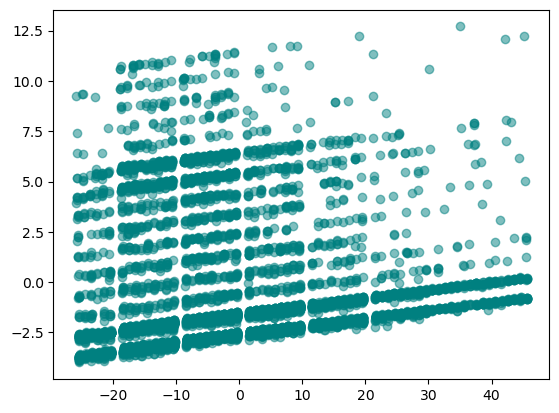

In [40]:
plt.scatter(X_tr_2D[:, 0], X_tr_2D[:, 1], c='teal', alpha=0.5)
plt.show()

In [41]:
#Plot 3D reduced dataset
X_tr_3D.shape

(5713, 3)

In [42]:
x = X_tr_3D[:, 0]
y = X_tr_3D[:, 1]
z = X_tr_3D[:, 2]

In [43]:
min(z), max(z)

(-2.647972293334547, 7.103499337065302)

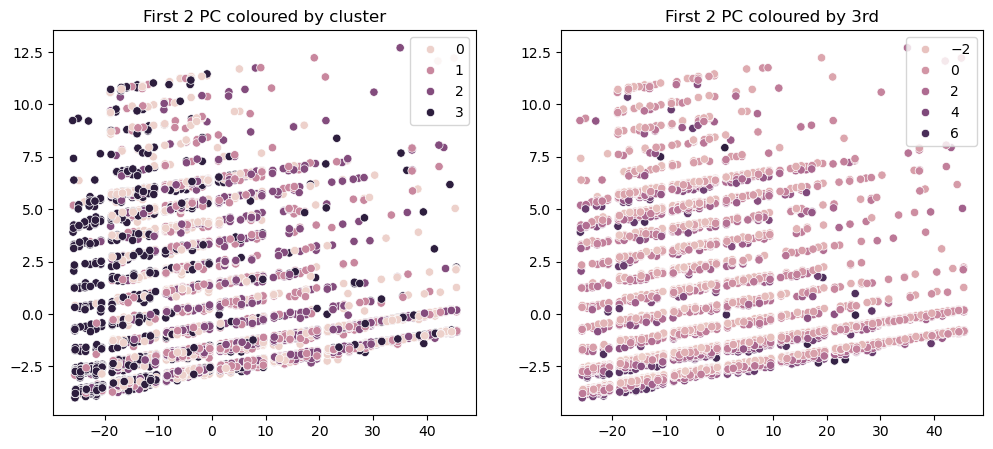

In [44]:
 #In 2 dimensions
fig, axes = plt.subplots(1, 2, figsize=(12,5))
  #First 2 principal components plotted in 2D, colored by label
sns.scatterplot(x=x, y=y, hue=y_tr, ax=axes[0])
axes[0].set_title('First 2 PC coloured by cluster')
  #First 2 principal components plotted in 2D, colored by 3rd PC
sns.scatterplot(x=x, y=y, hue=z, ax=axes[1])
axes[1].set_title('First 2 PC coloured by 3rd')
plt.show()

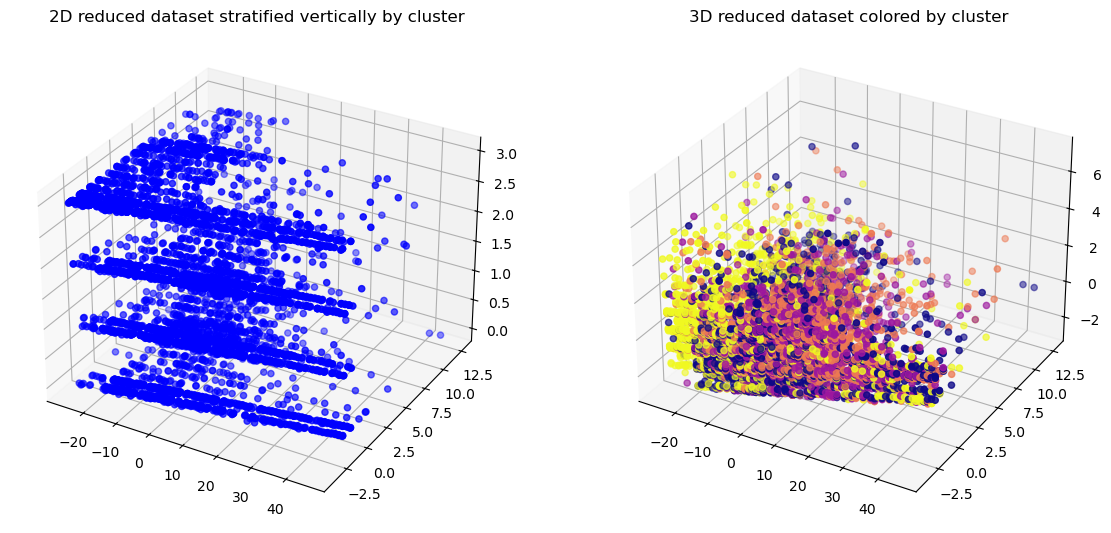

In [45]:
 #In 3 dimensions
  #First 2 principal components projected in 3 dimensional subspace, stratified vertically by label
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(14,12))
axes[0].scatter(x, y, y_tr, c='Blue', marker="o")
axes[0].set_title("2D reduced dataset stratified vertically by cluster")
  #First 2 principal components in 3 dimensional subspace, stratified vertically by label
axes[1].scatter(x, y, z, c=y_tr, cmap='plasma', marker="o")
axes[1].set_title("3D reduced dataset colored by cluster")
plt.show()

On the left, we can visualize how when reduced to 2 principal components, the instances seem to occupy characteristic 'x, y' regions based on label (with much overlap).

On the right, just like when we statistically assessed the explained variance of successive principal components earlier, we can visualize how the first 3 principal components projected into a 3D subspace still appear to mostly occupy a 2D plane, and that a third principal component may not contribute much variance/information; the cluster coloured yellow stands out as particularly distinct.

<br/>
<br/>

Now let's use silhouette analysis to evaluate the clusters assigned by our sales team.

Silhouette coefficients: calculated for each record, based on intracluster density and separation from the nearest cluster.
- Ideally, instances are situated firmly within their own cluster, which is relatively far from the nearest cluster

Silhouette scores: an aggregate of these coefficients across all instances.

For the assigned clusters, the silhouette score is: -0.028176089417995147


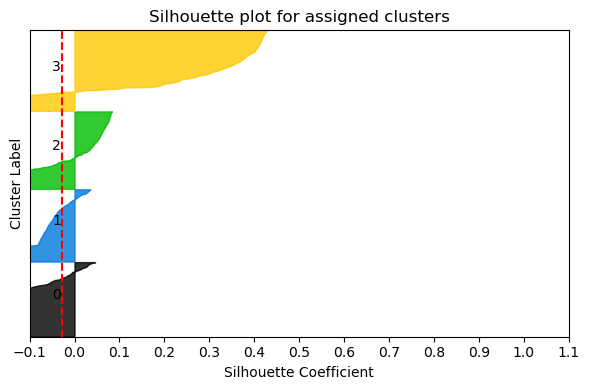

In [46]:
#Silhouette analysis: assigned labels

#Set clusters
k_val = [4]

#Create figure
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for idx, k in enumerate(k_val):
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X_tr) + (k + 1) * 10])

    #Calculate silhouette coefficients per record + output score
    silhouette_avg = silhouette_score(X_tr, y_tr)
    print("For the assigned clusters, the silhouette score is:", silhouette_avg)

    #Plot coefficients sorted and coloured by cluster
    sample_silhouette_values = silhouette_samples(X_tr, y_tr)
    y_lower = 10
    
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[y_tr == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.8,)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
#Format plot
ax.set_title("Silhouette plot for assigned clusters")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster Label")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xticks(np.arange(-0.1, 1.1, 0.1))

plt.tight_layout()
plt.show()

Since the assigned clusters don't take on a spherical/globular form, Kmeans is not very effective.\
The silhouette score and diagram above provide statistical support for this conclusion:
- Many instances have a negative silhouette coefficient, meaning they're likely assigned to the wrong cluster; this is captured in the mean (dashed red line)
- Many instances do not exceed the mean, indicating they're too close to other clusters

Let's try using unsupervised learning to predict new clusters from our training features at various levels of clustering, and evaluate the exploratory clusters.

In [47]:
#Get inertias and silhouette scores for multiple k values
k_vals = [2,3,4,5,6,7]

count_ine = 0

df_inertia = pd.DataFrame(columns=['Inertia', 'Predictions'])
df_silhouette = pd.DataFrame(columns=['Silhouette Score'])

for k in k_vals:
    #default k-means++ centroid initialization
    kmeans = KMeans(n_clusters=k, n_init=15)
    kmeans.fit(X_tr)
    df_inertia.loc[count_ine] = [kmeans.inertia_, kmeans.labels_]
    df_inertia.rename(index={count_ine: str(k_vals[count_ine])}, inplace=True)
    df_silhouette.loc[count_ine] = silhouette_score(X_tr, kmeans.labels_)
    df_silhouette.rename(index={count_ine: str(k_vals[count_ine])}, inplace=True)
    count_ine+=1

df_inertia.index.rename('k', inplace=True)
df_silhouette.index.rename('k', inplace=True)

print(df_inertia,'\n\n',df_silhouette)

         Inertia                                        Predictions
k                                                                  
2  594097.340772  [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, ...
3  324514.455591  [0, 1, 1, 2, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 2, ...
4  221344.794057  [2, 1, 1, 3, 2, 2, 3, 3, 2, 2, 3, 0, 2, 2, 3, ...
5  177423.212212  [4, 2, 2, 3, 0, 0, 2, 3, 4, 4, 2, 0, 0, 4, 2, ...
6  150383.350345  [5, 1, 1, 2, 0, 0, 1, 2, 0, 5, 1, 3, 0, 0, 1, ...
7  129822.920121  [4, 6, 6, 1, 0, 0, 1, 1, 0, 4, 1, 5, 0, 0, 1, ... 

    Silhouette Score
k                  
2          0.538529
3          0.464335
4          0.423972
5          0.398658
6          0.356245
7          0.348960


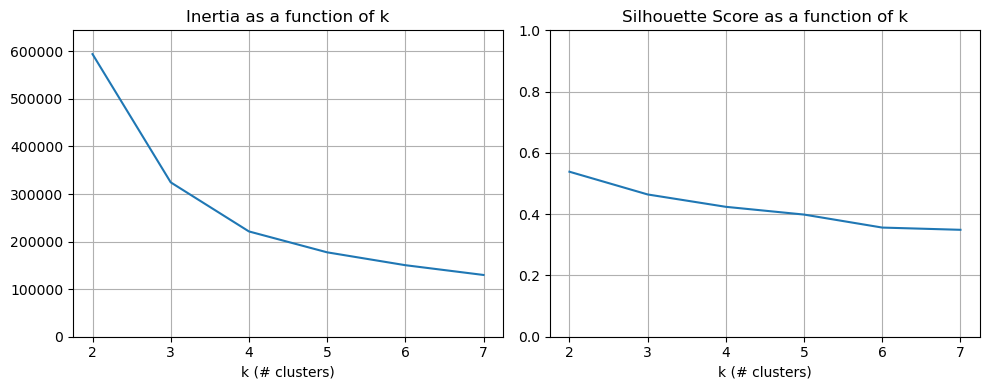

In [48]:
#Plot inertias and silhouette scores against k values
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

y_max = max(df_inertia['Inertia'])
y_tick_range = np.arange(0, y_max+50_000, 100_000)
df_inertia.plot(ax=axes[0], ylim=[0,y_max+50000], grid=True, xlabel='k (# clusters)', yticks=y_tick_range, title="Inertia as a function of k", legend=False)

df_silhouette.plot(ax=axes[1], ylim=[0,1], grid=True, xlabel='k (# clusters)', title="Silhouette Score as a function of k", legend=False)

plt.tight_layout()
plt.show()

The Inertia "elbow" is visible at around k = 4; this is consistent with the labels provided in the dataset (A, B, C, or D)\
Silhouette scores decrease as k increases

For 2 clusters, the silhouette score is: 0.5386489966209832
For 3 clusters, the silhouette score is: 0.464334502658579
For 4 clusters, the silhouette score is: 0.4239100039431261
For 5 clusters, the silhouette score is: 0.39491810603715743
For 6 clusters, the silhouette score is: 0.3563909321625346
For 7 clusters, the silhouette score is: 0.3476958968362601


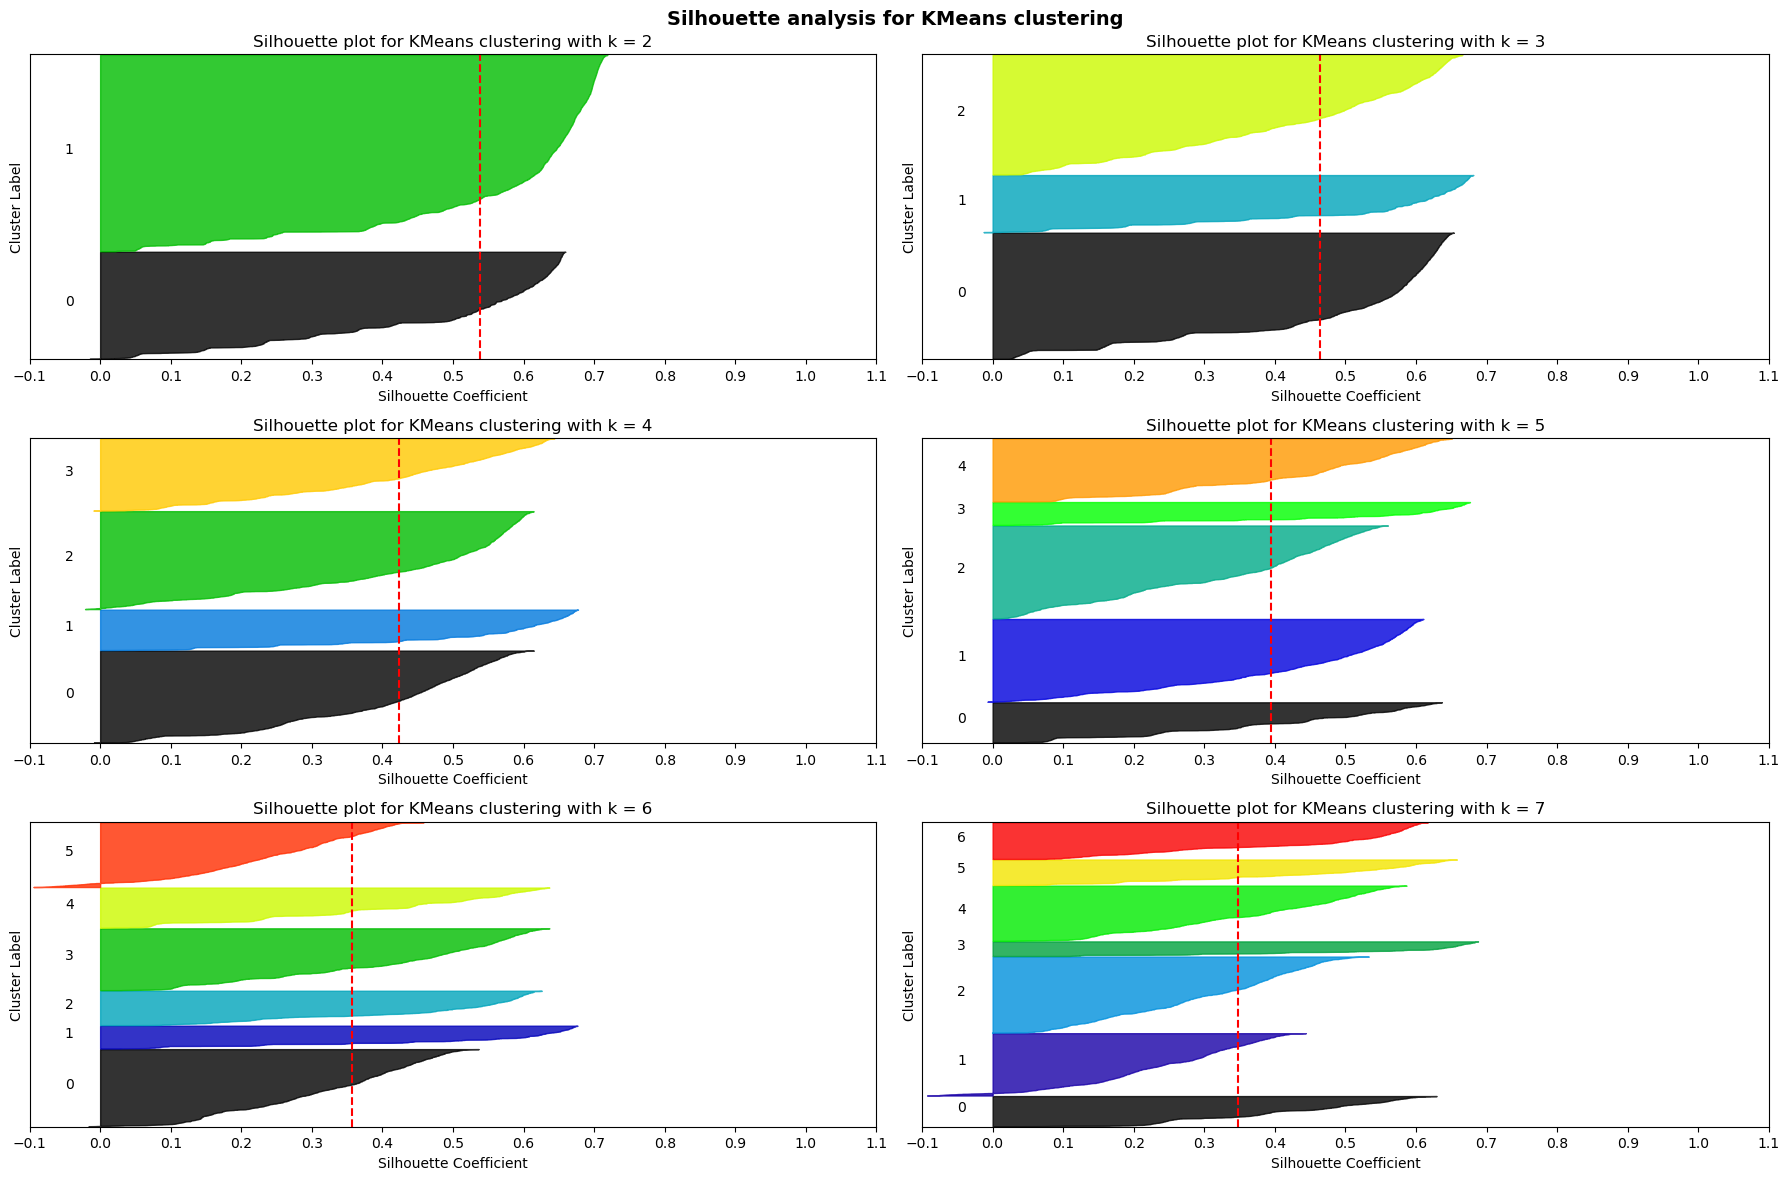

In [49]:
#Silhouette analysis: unsupervised predictions

#Set figure dimensions
num_rows = 3
num_cols = 2

#Create figure
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 2 * num_rows * num_cols))

#Plot figures for each k value
for idx, k in enumerate(k_vals):
    row = idx // num_cols
    col = idx % num_cols
    ax = axs[row, col]
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X_tr) + (k + 1) * 10])
    
    #Fit model + store predicted labels for each record
    clusterer = KMeans(n_clusters=k, n_init=15)
    cluster_labels = clusterer.fit_predict(X_tr)
    #Calculate silhouette coefficients per record + output score
    silhouette_avg = silhouette_score(X_tr, cluster_labels)
    print("For", k, "clusters, the silhouette score is:", silhouette_avg)

    #Plot coefficients sorted and coloured by cluster
    sample_silhouette_values = silhouette_samples(X_tr, cluster_labels)
    y_lower = 10
    
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.8,)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    #Format subplot
    ax.set_title("Silhouette plot for KMeans clustering with k = %d" % k)
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks(np.arange(-0.1, 1.1, 0.1))

#Format full plot
plt.suptitle("Silhouette analysis for KMeans clustering", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Above, at values of k = 5, 6, or 7 clusters we can see a few things:
- Some clusters become very small proportionally
- Many instances do not meet the mean silhouette score (dashed red line), indicating that they're too close to other clusters (i.e., there is high cluster overlap)
  - Related to this, as clusters increase more instances have a negative silhouette coefficient, further indicating that they may be assigned to the wrong cluster

At values of k = 2, 3 and 4:
- The silhouette score is highest at k = 2
- Most instances are well above the mean
- While k = 4 doesn't have the highest silhouette score, it may strike the best balance between low inertia (instances close to their nearest centroid) and high silhouette score (good cluster density and separation)